# How to detect peaks
This notebook demonstrates a quick way of finding and plotting peaks in data.


In [1]:
# First, the usual needs:

import random
from itertools import accumulate

import matplotlib as mpl
import matplotlib.pyplot as plt

import ipywidgets as widget

import hierarchical_peaks as hip

%matplotlib inline
plt.style.use('seaborn-talk')


We will use an example data set:

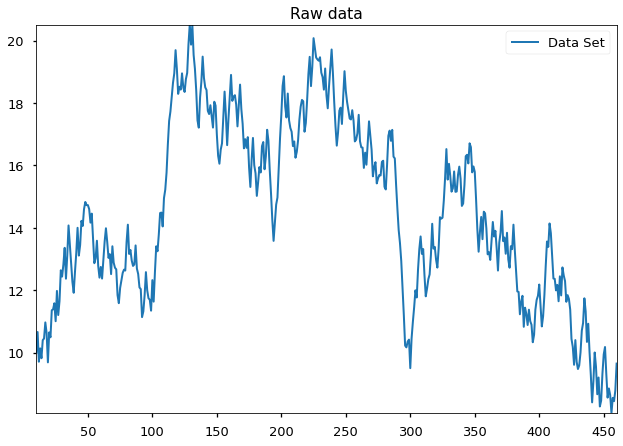

In [2]:
random.seed(a="It's...") # ref. Monty Python

# Generate a synthetic data set (X, Y):

X, Y = zip(*enumerate(accumulate((random.uniform(-1, 1) for n in range(450)), initial=10), start=10))


# plot to show the peaks that we are up against:

fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_title("Raw data")
ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

How do we detect peaks in this graph? We first make a tree out of our data set:

In [3]:
# Initialize a PeakTree object for the (X, Y) data set:

tree = hip.PeakTree(zip(X, Y))

The `tree` object has a method for finding peaks called `.filter()`:

In [4]:
peaks = sorted(tree.filter(maxsize=3.0))

print(peaks)

[12, 20, 22, 26, 73, 91, 98, 100, 103, 106, 114, 147, 153, 180, 192, 209, 218, 257, 266, 272, 275, 289, 298, 304, 311, 320, 352, 356, 361, 367, 377, 386, 391, 397, 403, 429, 431, 445, 448, 458]


In this `peaks` list, each peak is represented by its label in the `tree`.

How can we visualize them? First, we must extend the `tree` with an extra attribute:

In [5]:
# Bestow the tree with an attribute containing location intervals:

tree.location = hip.peak_locations([(x, tree.data[x]) for x in tree], zip(X, Y))

We will highlight each of the detected `peaks` by drawing a nice, red **bounding box** around it.

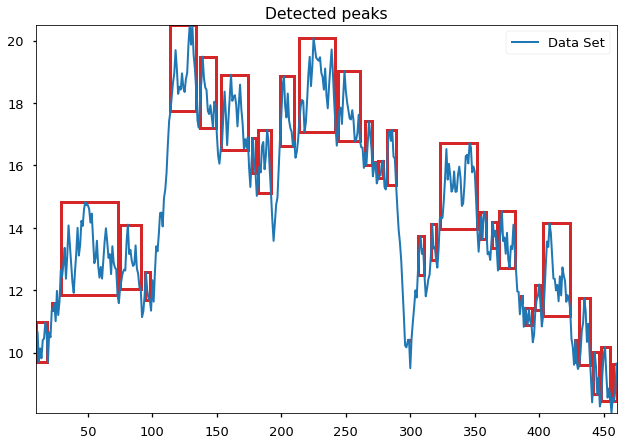

In [6]:
# Prepare a plot
fig, ax = plt.subplots()
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_title("Detected peaks")

for peak in peaks:
    x1, x2 = tree.location[peak]
    # add a red bounding box:
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, tree.base_height(peak)),
                                       width=x2 - x1,
                                       height=tree.size(peak),
                                       fill=False,
                                       linewidth=3,
                                       edgecolor="C3",
                                      ))

# And plot the data set in blue:
ax.plot(X, Y, lw=2, c="C0", label="Data Set")
ax.legend();

So, we have managed to detect and plot the peaks!

As one can perhaps find by inspecting the plotting code: The width of each bounding box is the width of the peak's `location` interval. And the height of each bounding box is the peak's `size`.

## The maxsize parameter
What `filter()` does internally is to find all nodes `x` in the `tree` for which:
- The size of `x` is below `maxsize`
- The size of the parent of `x` is above `maxsize` (unless `x` is root)

`maxsize` is a constant value, an upper bound on sizes that we set.

So the same list of `peaks` as was found by `filter()` can be found with a list comprehension:

In [7]:
maxsize = 3.0

by_list_comprehension = [x for x in tree if tree.size(x) < maxsize and tree.size(tree.parent(x)) >= maxsize]

peaks == by_list_comprehension

True

`filter()` takes the `maxsize` value as a keyword argument. The `maxsize` parameter controls the size of peaks. This can be explored in an interactive plot, in which we see the effect of changing the value of `maxsize`.

Let us have bounding boxes and some more cool elements in the plot:

In [8]:
# plotting functions to show one peak:

def add_bounding_box(ax, x1, x2, base_height, size):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, base_height),
                                       width= x2 - x1,
                                       height=size,
                                       fill=False,
                                       linewidth=3,
                                       edgecolor="C3",
                                      ))    

def add_pedestal(ax, x1, x2, base_height):
    ax.add_patch(mpl.patches.Rectangle(xy=(x1, 0),
                                       width=x2 - x1,
                                       height=base_height,
                                       fill=True,
                                       linewidth=1,
                                       edgecolor="C2",
                                       facecolor="gold",
                                       alpha=0.6,
                                      ))

def add_crown(ax, xslice, yslice, base_height):
    ax.fill_between(xslice, yslice, base_height,
                    facecolor='gold',
                    alpha=0.9,
                   )

In [9]:
# Matplotlib´s fill_between requires that we prepare slices of our (X, Y) data set:

Xslice = {x: X[X.index(x1): X.index(x2)+1]  for x, (x1, x2) in tree.location.items()}
Yslice = {x: Y[X.index(x1): X.index(x2)+1]  for x, (x1, x2) in tree.location.items()}

In [10]:
def find_and_plot_peaks(maxsize):

    # make a new plot:
    fig, ax = plt.subplots()
    ax.set_xlim([min(X),max(X)])
    ax.set_ylim([min(Y),max(Y)])
    ax.set_title("Interactive plot")

    # plot peaks for given maxsize value:
    for peak in tree.filter(maxsize=maxsize):
        add_crown(ax, Xslice[peak], Yslice[peak], tree.base_height(peak))
        add_pedestal(ax, *tree.location[peak], tree.base_height(peak))
        add_bounding_box(ax, *tree.location[peak], tree.base_height(peak), tree.size(peak))
    
    # plot data:
    ax.plot(X, Y, lw=2, c="C0", label="Data Set")
    ax.legend();

    
widget.interact(find_and_plot_peaks,
                maxsize=widget.FloatSlider(min=0,
                                        max=max(Y)-min(Y),
                                        step=0.1,
                                        value=3.0,
                                        continuous_update=True
                                        )
               );

# Now use the slider to change the maxsize parameter:

interactive(children=(FloatSlider(value=3.0, description='maxsize', max=12.449776443279841), Output()), _dom_c…

By increasing the maxsize with the slider, the sizes and widths of peaks increase and they merge into even larger peaks.

Note: A 'peak' in English sometimes means a point-like local maximum. 
But in the `hierarchical_peaks` software, a peak is rather a cluster with one or more local maxima.

Are you interested in the local maxima? `PeakTree` objects also have a method for that: `leaf_nodes()`. However, setting `maxsize=0` the resulting peaks shrink down and become equal to the local maxima.

In [11]:
# Verify that zero-size peaks are actually local maxima: 

sorted(tree.filter(maxsize=0)) == sorted(tree.leaf_nodes())

True

To summarize, peak finding follows these steps:
1. Feed data to a PeakTree instance `tree`
2. Set the location intervals using `hip.peak_locations`
3. Choose a value of `maxsize` and
4. Find a list of `peaks` by calling `tree.filter`
5. Plot ad libitum